# **Model 2**

제작 : 성현<br>
사용 기법 : 전이학습, InceptionV3<br>

> **모델 간략한 소개**

1. 레이어 일부 동결헤제<br>
2. lr schedule<br>
3. EarlyStopping Method<br>

> **모델 성능**

ACC : **91.82%** <br>
LOSS : **0.2833** <br>
F1 SCORE : **0.5660377358490566** <br>

모델 학습 시 loss, val_loss, acc, val_acc 그래프 아래 첨부할 것.

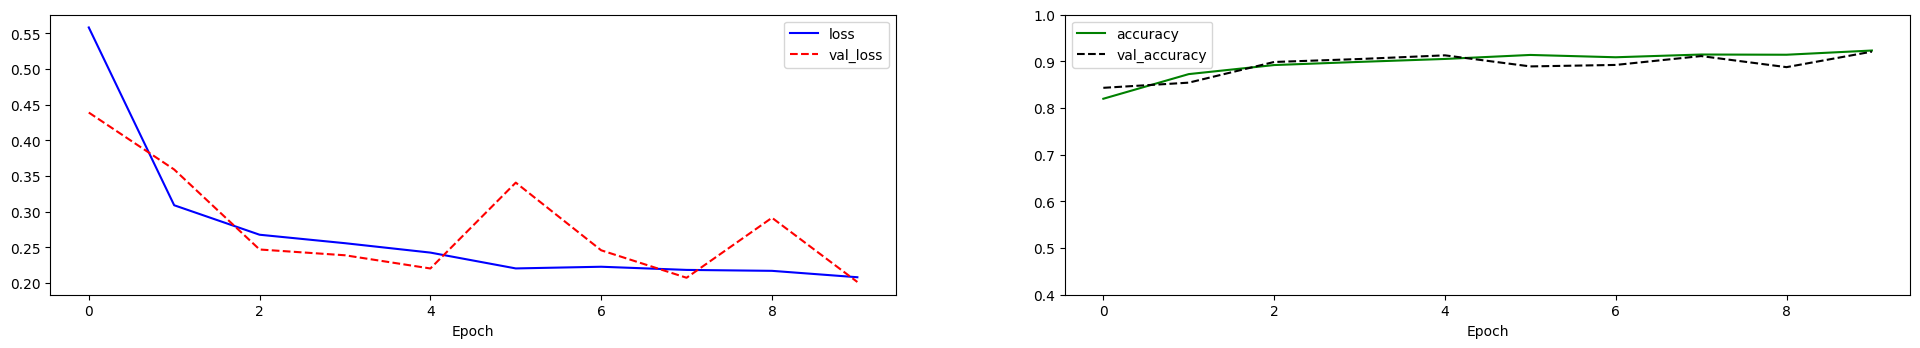

### **GPU 설정**

In [3]:
import tensorflow as tf

# GPU 디바이스 확인
tf.test.gpu_device_name()

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# TensorFlow가 GPU를 사용할 수 있도록 설정합니다.
if len(tf.config.list_physical_devices('GPU')) > 0:
    print('GPU is enabled')
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)


Num GPUs Available:  1
GPU is enabled


### **모듈 import**

In [4]:
import os
import tensorflow as tf
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from keras.applications import InceptionV3
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score
from tensorflow.keras.optimizers import Adam

### **프로젝트 공통 설정**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
test_data_path = '/content/drive/MyDrive/PneumoniaClassifier/data/test'
val_data_path = '/content/drive/MyDrive/PneumoniaClassifier/data/val'
train_data_path = '/content/drive/MyDrive/PneumoniaClassifier/data/train'

In [5]:
def count_data_number(path, name):
    pneumonia = 0
    normal = 0

    # pneumonia 폴더 내의 파일 개수 계산
    pneumonia_path = os.path.join(path, 'PNEUMONIA')
    if os.path.exists(pneumonia_path):
        pneumonia = len(os.listdir(pneumonia_path))

    # normal 폴더 내의 파일 개수 계산
    normal_path = os.path.join(path, 'NORMAL')
    if os.path.exists(normal_path):
        normal = len(os.listdir(normal_path))

    print(name, "pneumonia data : ", pneumonia)
    print(name, "normal data : ", normal)
    print()

    return pneumonia, normal

In [6]:
count_data_number(train_data_path, "train")
count_data_number(val_data_path, "val")
count_data_number(test_data_path, "test")

train pneumonia data :  1108
train normal data :  1108

val pneumonia data :  316
val normal data :  316

test pneumonia data :  159
test normal data :  159



(159, 159)

## **모델 개발**

In [7]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(
  train_data_path,
  target_size=(200, 200),
  batch_size=1,
  class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
  val_data_path,
  target_size=(200, 200),
  batch_size=1,
  class_mode='categorical'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

test_generator = test_datagen.flow_from_directory(
  test_data_path,
  target_size=(200, 200),
  batch_size=1,
  class_mode='categorical'
)

Found 2216 images belonging to 2 classes.
Found 632 images belonging to 2 classes.
Found 318 images belonging to 2 classes.


In [8]:
input_shape = (200, 200, 3)
model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape, pooling='max')
x = Dropout(0.5)(model.output)
x = Dense(64, activation='relu')(x)
outputs = Dense(2, activation='softmax')(x)
model = tf.keras.Model(inputs=model.input, outputs=outputs)



initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

for layer in model.layers:
    layer.trainable = False
for layer in model.layers[-5:]:
    layer.trainable = True

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule),
              metrics=['accuracy'])

model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=3)


87910968/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 99, 99, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 99, 99, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                             

In [9]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator,
                    batch_size=20,
                    callbacks=[early_stop])

model.save('/content/drive/MyDrive/PneumoniaClassifier/model/model2.h5')

In [ ]:
# 테스트 데이터 평가
model.evaluate(test_generator)

318/318 [==============================] - 77s 242ms/step - loss: 0.2833 - accuracy: 0.9182


[0.28329870104789734, 0.9182389974594116]

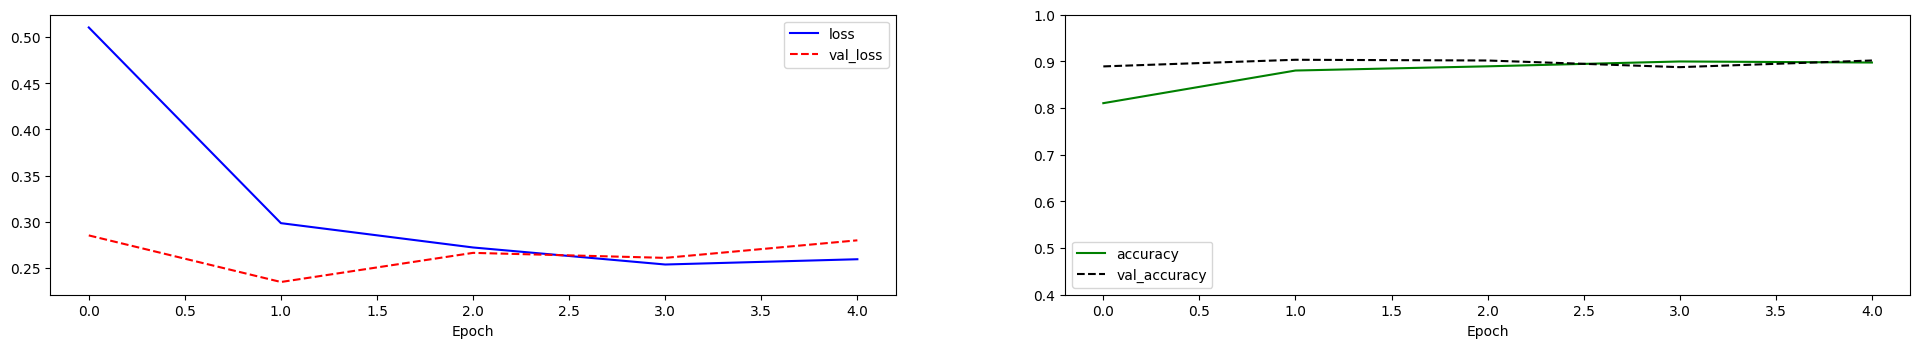

In [ ]:
plt.figure(figsize=(24,8))

plt.subplot(2,2,1)
plt.plot(history.history['loss'],'b-',label='loss')
plt.plot(history.history['val_loss'],'r--',label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'],'g-',label='accuracy')
plt.plot(history.history['val_accuracy'],'k--',label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.4,1.0)
plt.legend()

## **모델 평가**

In [ ]:
# 테스트 데이터에 대한 예측 수행
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # 클래스 예측값으로 변환

# 실제 레이블 가져오기
y_true = test_generator.classes

from sklearn.metrics import precision_score, recall_score, f1_score
# F1 점수 계산
f1 = f1_score(y_pred_classes, y_true)

print(y_true)
print(y_pred_classes)

print('F1 Score:', f1)

318/318 [==============================] - 9s 23ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0 1 1 0 1 0 0 1 1 1
 1 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 1 1 0 1 1 0
 1 1 1 1 0 0 0 1 1 1 0 1 1 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0
 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 